## Streetview Image Classification Using a CNN: Investigating Impacts of Data Engineering and Use of Pretrained VGG

The ultimate goal of this project is to accurately predict building use (e.g. residential, commercial, industrial) given a photograph of the building's exterior. If successful, this classifier could be used to help with a wider project that is looking to quantify material stocks in Toronto. Building use has an impact on construction type, and so accurately predicting building use is a key component of this effort.

The training data for this project comes from two sources:
- A labelled set of building typologies exists in the publically available [Building Permits](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#c9117f72-4eaf-5e45-f3a6-b8b465074217) from the City of Toronto
- Images for each location were downloaded in a 600x400 resolution using the google streetview API. This script can be found in the Image_Retriever notebook.

## Imports

In [1]:
import os
import shutil
import numpy as np
#import cPickle
#import _pickle as cPickle #uncomment this on the VM for it to work
import pandas as pd 
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

"""
import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
"""

'\nimport tensorflow as tf\nimport tensorflow.python.keras\nfrom tensorflow.python.keras.models import Sequential \nfrom tensorflow.python.keras.models import model_from_json\nfrom tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization\nfrom tensorflow.python.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D\nfrom tensorflow.python.keras import backend as K\nfrom tensorflow.python.keras import regularizers\n'

### Sorting Data scraped from Google Streetview


The data output from the image_retriever is in one large folder, not separated by class. This short script moves images into different folders based on their class

In [22]:
#contains the labels
labeledDF = pd.read_excel('Classifier_Building_Data.xlsx', sheet_name='Sheet2')

In [41]:
os.mkdir("Data/")
for i in labeledDF['New Typology'].unique():
    os.mkdir("Data/" + str(i))

In [52]:
for i in range(1,21):
    teststr = str(i)
    counter = 0
    path = 'Project/'+teststr
    for filename in os.listdir(path):
        address = filename[:filename.find(',')]
        typology = labeledDF.loc[labeledDF['Address'] == address, 'New Typology'].iloc[0]
        src = path+"/"+filename
        dst = 'Data/'+typology
        exists = os.path.isfile(dst +"/"+filename)
        if exists:
            counter += 1
            print(counter)
        else:
            shutil.move(src,dst)

## Formatting Images for Use in the CNN
Images were pulled from google streetview in a 600x400 pixel format. In order to meet this resolution requirement, the google streetview API cut pixels from all margins of image in order to end with a 600x400 image of the center of the image. This focuses the images on the structure of interest, as being taken from google streetview these images often include a large amount of lawn / sky.

To go from the 600x400 to the 64x64 or 32x32 format for classification, my first step is to cut a square from the image (256x256). This Square will then be compressed down to the 64x64 or 32x32 format for classification

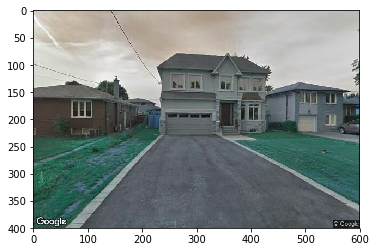

In [5]:
#Sample starting image
import cv2
image = cv2.imread("test.jpg")

plt.imshow(image)
plt.show()

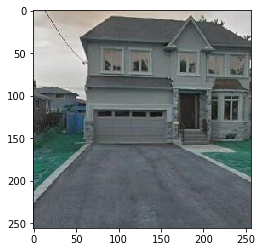

In [16]:
#cropping to 256 by 256 square
height = int(image.shape[0])
width = int(image.shape[1])

if ((height >= 256) and (width >= 256)):
    y_start = (height - 256) / 2
    x_start = (width - 256) / 2
    crop_img = image[y_start:(y_start+256), x_start:(x_start+256)]

plt.imshow(crop_img)
plt.show()

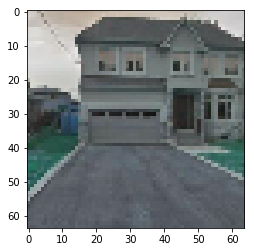

In [19]:
#lowering resolution for ease of CNN training
new_res = 64

scaled_img = cv2.resize(crop_img, (new_res, new_res))

plt.imshow(scaled_img)
plt.show()

In [20]:
cv2.imwrite("test_cropped.jpg", scaled_img)

True

In [37]:
import cv2

class_list = labeledDF['New Typology'].unique()

#creating output folders
os.mkdir('32_Scaled')
for i in class_list:
    os.mkdir('32_Scaled/' + i)

counter = 0
for i in class_list:
    path = 'Data/' + i
    for filename in os.listdir(path):
        out_path = '32_Scaled/' + i +'/' + filename
        
        image_read = cv2.imread(path+"/"+filename)
        
        #cropping to 256 by 256 square
        height = int(image_read.shape[0])
        width = int(image_read.shape[1])

        if ((height >= 256) and (width >= 256)):
            y_start = (height - 256) / 2
            x_start = (width - 256) / 2
            crop_img = image_read[y_start:(y_start+256), x_start:(x_start+256)]
        
            scaled_img = cv2.resize(crop_img, (32,32))
            
            #plt.imshow(scaled_img)
            #plt.show()
            
            cv2.imwrite(out_path, scaled_img)
        else:
            counter += 1
            print(counter)

In [35]:
counter = 0
for i in ['Industrial']:
    path = 'Data/' + i
    for filename in os.listdir(path):
        out_path = '64_Scaled/' + i +'/' + filename
        
        image_read = cv2.imread(path+"/"+filename)
        
        #cropping to 256 by 256 square
        height = int(image_read.shape[0])
        width = int(image_read.shape[1])

        if ((height >= 256) and (width >= 256)):
            y_start = (height - 256) / 2
            x_start = (width - 256) / 2
            crop_img = image_read[y_start:(y_start+256), x_start:(x_start+256)]
        
            scaled_img = cv2.resize(crop_img, (64,64))
            
            #plt.imshow(scaled_img)
            #plt.show()
            
            cv2.imwrite(out_path, scaled_img)
        else:
            counter += 1
            print(counter)

In [26]:
for i in class_list:
    print(i)

Detached House
Attached House
Small Commercial
Office
Apartment
Institutional
Industrial
Commercial
